<a href="https://colab.research.google.com/github/Everysimo/DarkPattern_Thesis/blob/main/DarkPattern_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificazione Dark Pattern

## Ottenimento del dataset

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from six.moves import urllib
from matplotlib import style
import missingno as msno
import pickle
import imblearn

style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (20,10)

DOWNLOAD_ROOT="https://raw.githubusercontent.com/Everysimo/DarkPattern_Thesis/main/dark-patterns-v2.csv"

#fetch del dataset da github
def fetch_file_data1(file_url1=DOWNLOAD_ROOT, file_path1="file"):
  os.makedirs(file_path1, exist_ok=True)
  csv_path1 = os.path.join(file_path1, "dataset.csv")
  urllib.request.urlretrieve(file_url1, csv_path1)
fetch_file_data1()

#df è la variabile che contiene il dataset
df=pd.read_csv("file/dataset.csv")
df=df[["Pattern String", "Comment", "Pattern Category", "Pattern Type", "Where in website?", "Deceptive?", "Website Page"]]
df.head(5)

,Pattern String,Comment,Pattern Category,Pattern Type,Where in website?,Deceptive?,Website Page
0,Collin P. from Grandview Missouri just bought ...,Periodic popup,Social Proof,Activity Notification,Product Page,No,https://alaindupetit.com/collections/all-suits...
1,"Faith in Glendale, United States purchased a C...",Periodic popup,Social Proof,Activity Notification,Product Page,No,https://bonescoffee.com/products/strawberry-ch...
2,Sharmeen Atif From Karachi just bought Stylish...,Periodic popup,Social Proof,Activity Notification,Product Page,No,https://brandsego.com/collections/under-rs-99/...
3,9 people are viewing this.,Product detail,Social Proof,Activity Notification,Product Page,No,https://brightechshop.com/products/ambience-so...
4,5338 people viewed this in the last hour,Periodic popup,Social Proof,Activity Notification,Product Page,No,https://bumpboxes.com/


## 1) Data Cleaning

### 1.1) Descrizione del dataset

In [ ]:
#descrizione del dataset
df.describe()

,Pattern String,Comment,Pattern Category,Pattern Type,Where in website?,Deceptive?,Website Page
count,1512,1798,1818,1818,1818,1818,1818
unique,1178,371,7,15,5,3,1398
top,Only 1 left,Product detail,Scarcity,Low-stock Message,Product Page,No,https://fuzz.online/products/fg-grater
freq,26,684,679,632,1609,1584,11


### 1.2) Verifica valori null nel dataset

In [ ]:
#verifica se ci sono dati null nel dataset
df.isnull().any()
df.isnull().sum()

Pattern String       306
Comment               20
Pattern Category       0
Pattern Type           0
Where in website?      0
Deceptive?             0
Website Page           0
dtype: int64

In [ ]:
#verifica se ci sono dati NA nel dataset
print(df.isna().any())
df.isna().sum()

Pattern String        True
Comment               True
Pattern Category     False
Pattern Type         False
Where in website?    False
Deceptive?           False
Website Page         False
dtype: bool


Pattern String       306
Comment               20
Pattern Category       0
Pattern Type           0
Where in website?      0
Deceptive?             0
Website Page           0
dtype: int64

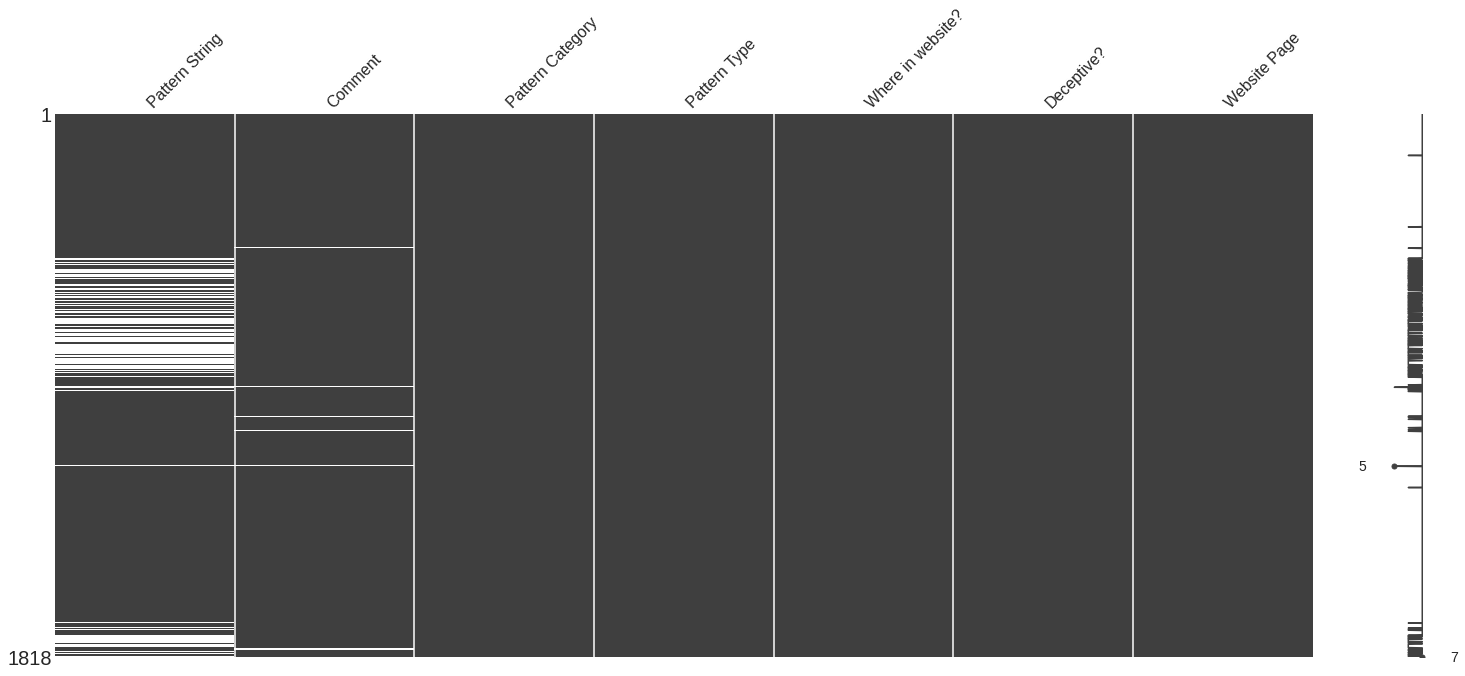

In [ ]:
%matplotlib inline
msno.matrix(df)

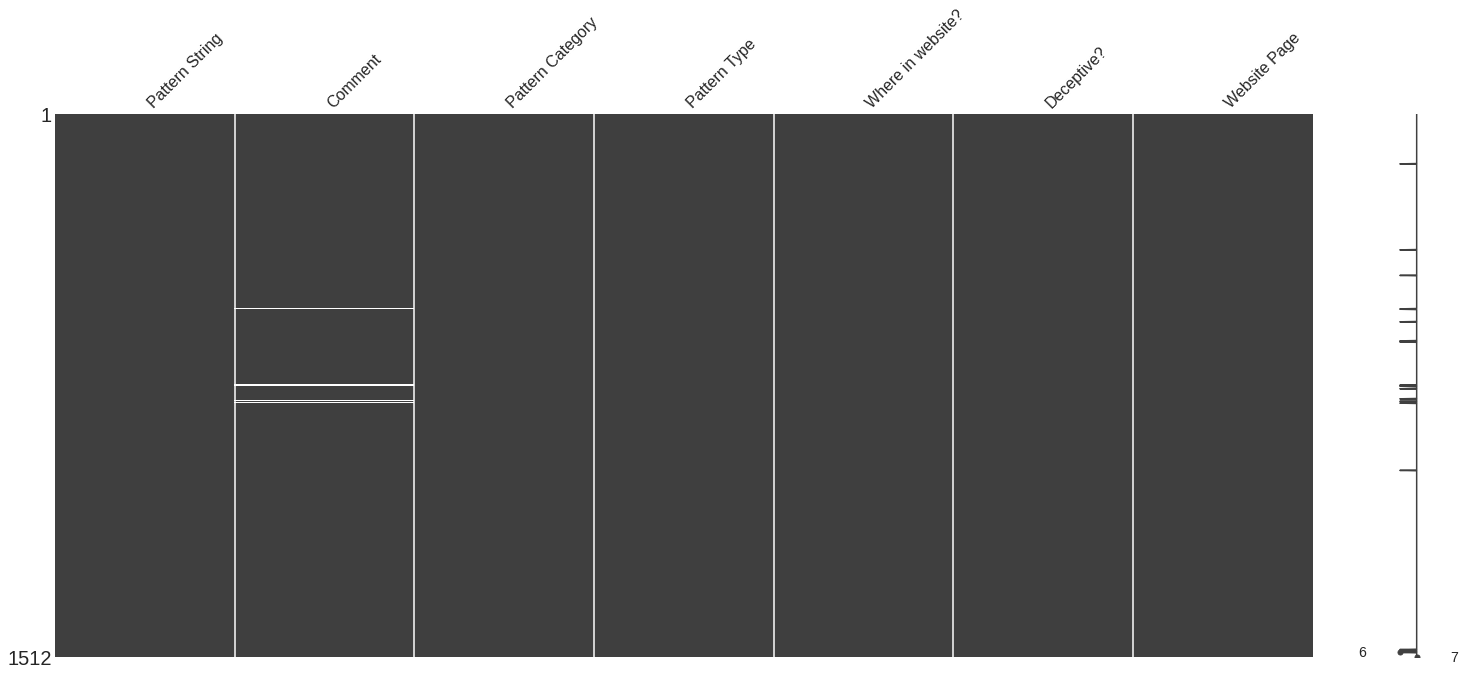

In [ ]:
df = df.dropna(subset=['Pattern String'])
%matplotlib inline
msno.matrix(df)

### 1.3) Feature Selection

In [ ]:
df=df[["Pattern String", "Pattern Type"]]
df.head(5)

,Pattern String,Pattern Type
0,Collin P. from Grandview Missouri just bought ...,Activity Notification
1,"Faith in Glendale, United States purchased a C...",Activity Notification
2,Sharmeen Atif From Karachi just bought Stylish...,Activity Notification
3,9 people are viewing this.,Activity Notification
4,5338 people viewed this in the last hour,Activity Notification


## 2)Text Pre-Processing

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
import re

nltk.download('stopwords')
stemmer = PorterStemmer()
words = stopwords.words("english")

df['Pattern String'] = df['Pattern String'].fillna('').apply(str)
df['Pattern String'] = df['Pattern String'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z\$]", " ", x).split() if i not in words]).lower())

df.head(5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Pattern String,Pattern Type
0,collin p grandview missouri bought burgundi tw...,Activity Notification
1,faith glendal unit state purchas choos your fl...,Activity Notification
2,sharmeen atif from karachi bought stylish meta...,Activity Notification
3,peopl view,Activity Notification
4,peopl view last hour,Activity Notification


##3)Creazione Modelli

### RandomForestClassifier

In [ ]:
from sklearn.model_selection import RepeatedKFold, KFold
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold

#Scelta variabile dipendente (y) e indipendenti (X)
X = df['Pattern String']
y = df['Pattern Type']

vectorizer = TfidfVectorizer(min_df= 3,stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))

tfidf_transformer = TfidfTransformer()

#Usiamo una Pipeline per automatizzare i vari setp
steps = [
         ('vect', vectorizer),
         ('over', RandomOverSampler(sampling_strategy='minority')),
         ('tfidf', TfidfTransformer()),
         ('chi',  SelectKBest(chi2, k=100)),
         ('clf', RandomForestClassifier())]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedKFold(n_splits=40, n_repeats=40, random_state=42)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1_micro',
           'precision': 'precision_micro',
           'recall': 'recall_micro'}
scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv)
print(scores.keys())
print("Accuracy: ",np.mean(scores['test_accuracy']))
print("F1_micro: ",np.mean(scores['test_f1']))
print("Precision_micro: ",np.mean(scores['test_precision']))
print("Recall_micro: ",np.mean(scores['test_recall']))

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall'])
Accuracy:  0.9063175675675678
F1_micro:  0.9063175675675675
Precision_micro:  0.9063175675675678
Recall_micro:  0.9063175675675678


Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

#Scelta variabile dipendente (y) e indipendenti (X)
X = df['Pattern String']
y = df['Pattern Type']

steps = [
         ('vect', vectorizer),
         ('over', RandomOverSampler(sampling_strategy='minority')),
         ('tfidf', TfidfTransformer()),
         ('chi',  SelectKBest(chi2, k=100)),
         ('clf', MultinomialNB())]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedKFold(n_splits=40, n_repeats=40, random_state=42)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1_micro',
           'precision': 'precision_micro',
           'recall': 'recall_micro'}

scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv)
print(scores.keys())
print("Accuracy: ",np.mean(scores['test_accuracy']))
print("F1_micro: ",np.mean(scores['test_f1']))
print("Precision_micro: ",np.mean(scores['test_precision']))
print("Recall_micro: ",np.mean(scores['test_recall']))

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall'])
Accuracy:  0.8108641536273115
F1_micro:  0.8108641536273115
Precision_micro:  0.8108641536273115
Recall_micro:  0.8108641536273115


KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

#Scelta variabile dipendente (y) e indipendenti (X)
X = df['Pattern String']
y = df['Pattern Type']

steps = [
         ('vect', vectorizer),
         ('over', RandomOverSampler(sampling_strategy='minority')),
         ('tfidf', TfidfTransformer()),
         ('chi',  SelectKBest(chi2, k=100)),
         ('clf', KNeighborsClassifier())]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedKFold(n_splits=40, n_repeats=40, random_state=42)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1_micro',
           'precision': 'precision_micro',
           'recall': 'recall_micro'}

scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv)
print(scores.keys())
print("Accuracy: ",np.mean(scores['test_accuracy']))
print("F1_micro: ",np.mean(scores['test_f1']))
print("Precision_micro: ",np.mean(scores['test_precision']))
print("Recall_micro: ",np.mean(scores['test_recall']))

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall'])
Accuracy:  0.8940362731152206
F1_micro:  0.8940362731152206
Precision_micro:  0.8940362731152206
Recall_micro:  0.8940362731152206


LinearSVC

In [ ]:
from sklearn.svm import LinearSVC

#Scelta variabile dipendente (y) e indipendenti (X)
X = df['Pattern String']
y = df['Pattern Type']

steps = [
         ('vect', vectorizer),
         ('over', RandomOverSampler(sampling_strategy='minority')),
         ('tfidf', TfidfTransformer()),
         ('chi',  SelectKBest(chi2, k=100)),
         ('clf', LinearSVC())]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedKFold(n_splits=40, n_repeats=40)

scoring = {'accuracy': 'accuracy',
           'f1': 'f1_micro',
           'precision': 'precision_micro',
           'recall': 'recall_micro'}

scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv)
print(scores.keys())
print("Accuracy: ",np.mean(scores['test_accuracy']))
print("F1_micro: ",np.mean(scores['test_f1']))
print("Precision_micro: ",np.mean(scores['test_precision']))
print("Recall_micro: ",np.mean(scores['test_recall']))

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall'])
Accuracy:  0.9112784495021338
F1_micro:  0.9112784495021338
Precision_micro:  0.9112784495021338
Recall_micro:  0.9112784495021338
